<a href="https://colab.research.google.com/github/JoelGV/ReconocimientoPlacasAutos/blob/main/ReconocimientoPlacasAutos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconocimiento de placas de autos
En el siguiente código se utiliza el modelo Yolo v3 para reconocer la placa de los autos y se aplican herramientas de OCR (optical character recognition) para extraer los caracteres de la placa.

In [ ]:
import cv2
import argparse
import sys
import numpy as np
import os.path
import matplotlib.pyplot as plt

In [ ]:
# Initialize the parameters
confThreshold = 0.85  # Confidence threshold
nmsThreshold = 0.75  # Non-maximum suppression threshold

inpWidth = 416  # 608     # Width of network's input image
inpHeight = 416  # 608     # Height of network's input image

# Load names of classes
ruta = '/content/drive/MyDrive/DeteccionPlaca/'
classesFile = "classes.names"
classes = None
with open(ruta+classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

# Give the configuration and weight files for the model and load the network using them.

modelConfiguration = ruta + "yolov3.cfg"
modelWeights = ruta + "model.weights"

net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# Draw the predicted bounding box
def drawPred(frame, classId, conf, left, top, right, bottom):
    # Draw a bounding box.
    cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 3)
    
    label = 'Clase: Placa'

    # Display the label at the top of the bounding box
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(
        1.5*labelSize[0]), top + baseLine), (255, 0, 255), cv2.FILLED)
    cv2.putText(frame, label, (left, top),
               cv2.FONT_HERSHEY_SIMPLEX, 0.70, (255, 255, 255), 2)

# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    classIds = []
    confidences = []
    boxes = []
    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        print("out.shape : ", out.shape)
        for detection in out:
            # if detection[4]>0.001:
            scores = detection[5:]
            classId = np.argmax(scores)
            # if scores[classId]>confThreshold:
            confidence = scores[classId]
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    left = 0
    top = 0 
    width = 0
    height = 0
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(frame, classIds[i], confidences[i], left,
                 top, left + width, top + height)
        print('caja ', i, '(', left, top, left + width, top + height, ')')
    return left, top, left + width, top + height

out.shape :  (507, 85)
out.shape :  (2028, 85)
out.shape :  (8112, 85)
caja  0 ( 167 301 578 440 )


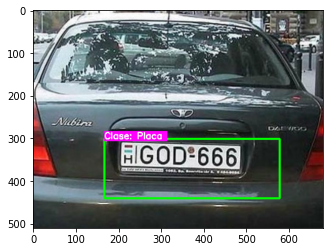

In [ ]:
img = cv2.imread('p_4.jpg')
imgBGR = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

blob = cv2.dnn.blobFromImage(img, 1/255, (inpWidth, inpHeight), [0, 0, 0], 1, crop=False)

# Sets the input to the network
net.setInput(blob)

# Runs the forward pass to get output of the output layers
outs = net.forward(getOutputsNames(net))

# Remove the bounding boxes with low confidence
x1, y1, x2, y2 = postprocess(imgBGR, outs)

# Put efficiency information. The function getPerfProfile returns the overall time for inference(t) and the timings for each of the layers(in layersTimes)

plt.imshow(imgBGR, cmap = 'Accent')
plt.show()

In [ ]:
# Así instalamos líbrerias que no estan por default en Colaboratory
!pip install pytesseract
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libtesseract-dev is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [ ]:
import pytesseract # Librerí para OCR

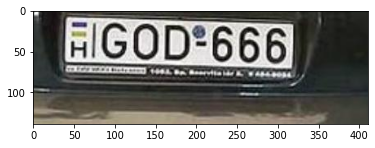

In [ ]:
placa = img[y1:y2, x1:x2, :]
plt.imshow(placa, cmap = 'Accent')
plt.show()

In [ ]:
texto = pytesseract.image_to_string(placa)
print(texto)

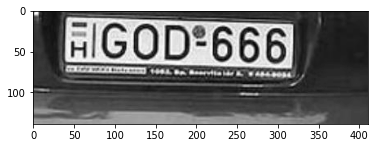

In [ ]:
 # Convertimos a escala de grises
imagenGray = cv2.cvtColor(placa, cv2.COLOR_RGB2GRAY)

plt.imshow(imagenGray, cmap='gray')
plt.show()

In [ ]:
texto2_1 = pytesseract.image_to_string(imagenGray)
print(texto2_1)

a GOD*666)

 



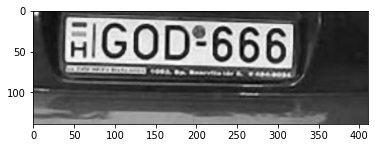

In [ ]:
# Filtro de mediana sobre la imagen
imagenFiltrada = cv2.medianBlur(imagenGray, 3)

plt.imshow(imagenFiltrada, cmap='gray')
plt.show()

In [ ]:
texto2_1 = pytesseract.image_to_string(imagenFiltrada)
print(texto2_1)

HIGOD*666

ores

4
aie

 



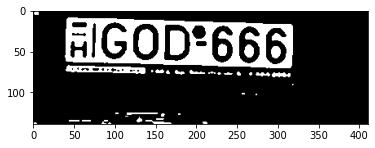

In [ ]:
# Binarizado por medio de un límite
ret, imagenBin1 = cv2.threshold(imagenFiltrada, 160,1, cv2.THRESH_BINARY)
plt.imshow(imagenBin1, cmap='gray')
plt.show()

In [ ]:
texto3 = pytesseract.image_to_string(imagenBin1)
print(texto3)

B-ICOD*666

ae

